In [93]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from datetime import datetime, timedelta
from math import radians, sin, cos, sqrt, atan2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load the Massachusetts shapefile
shapefile_path = "CENSUS2020TOWNS_ARC.shp"
ma_boundaries = gpd.read_file(shapefile_path)

# Step 1: Check the existing CRS
print(f"Original CRS: {ma_boundaries.crs}")

# Step 2: Assign the correct CRS if missing (e.g., EPSG:26986 for Massachusetts State Plane)
if ma_boundaries.crs is None:
    print("Assigning the original CRS (e.g., EPSG:26986 for Massachusetts State Plane)...")
    ma_boundaries = ma_boundaries.set_crs(epsg=26986)  # Replace with the actual CRS if known

# Step 3: Reproject to WGS84 (latitude/longitude)
print("Reprojecting to WGS84 (latitude/longitude)...")
ma_boundaries = ma_boundaries.to_crs(epsg=4326)

print(f"Reprojected CRS: {ma_boundaries.crs}")

Original CRS: None
Assigning the original CRS (e.g., EPSG:26986 for Massachusetts State Plane)...
Reprojecting to WGS84 (latitude/longitude)...
Reprojected CRS: epsg:4326


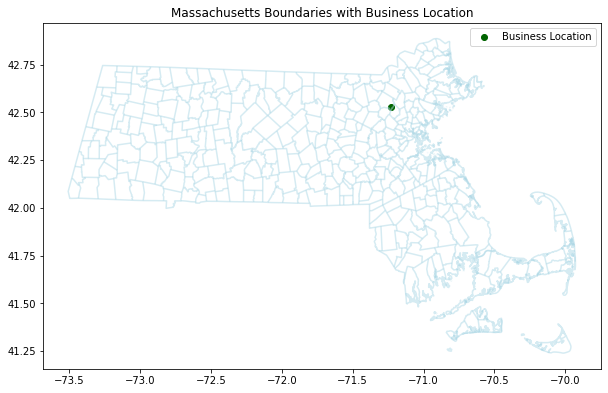

In [84]:
# Step 5: Define business location and delivery zone
business_location = Point(-71.22844677712773, 42.52998149804952)  # Longitude, Latitude for Boston
buffer_radius = 20 / 69  # Convert 20 miles to degrees
delivery_zone = business_location.buffer(buffer_radius)

# Step 6: Visualize the delivery zone
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ma_boundaries.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
plt.scatter(*business_location.xy, color='darkgreen', label="Business Location")
plt.title("Massachusetts Boundaries with Business Location")
plt.legend()
plt.show()

In [85]:
# Step 4: Define the business location (Boston example) and buffer radius
buffer_radius = 20 / 69  # Convert 20 miles to degrees (approximation)

# Step 5: Create the delivery zone (20-mile buffer) as a GeoDataFrame
delivery_zone = business_location.buffer(buffer_radius)
delivery_zone_gdf = gpd.GeoDataFrame(
    {"name": ["Delivery Zone"]},
    geometry=[delivery_zone],
    crs="EPSG:4326"
)

# Step 6: Reproject data to a projected CRS for accurate calculations
if ma_boundaries.crs is None:
    ma_boundaries = ma_boundaries.set_crs("EPSG:4326")  # Ensure CRS is set

projected_crs = "EPSG:26986"  # Example: Massachusetts State Plane
ma_boundaries_projected = ma_boundaries.to_crs(projected_crs)
delivery_zone_projected = delivery_zone_gdf.to_crs(projected_crs)

# Step 7: Check for intersections with the delivery zone
print("Checking intersections with the delivery zone...")
ma_boundaries_within_radius = ma_boundaries_projected.loc[
    ma_boundaries_projected.geometry.apply(lambda geom: geom.intersects(delivery_zone_projected.geometry.iloc[0]))
]

# Step 8: Calculate centroids in the projected CRS and reproject to WGS84
ma_boundaries_within_radius = ma_boundaries_within_radius.copy()  # Avoid SettingWithCopyWarning
ma_boundaries_within_radius["geometry_centroid"] = ma_boundaries_within_radius.geometry.centroid
ma_boundaries_within_radius = ma_boundaries_within_radius.to_crs("EPSG:4326")
ma_boundaries_within_radius["longitude"] = ma_boundaries_within_radius.geometry_centroid.x
ma_boundaries_within_radius["latitude"] = ma_boundaries_within_radius.geometry_centroid.y

# Display results
print(f"Number of intersecting features: {len(ma_boundaries_within_radius)}")
if len(ma_boundaries_within_radius) > 0:
    print(ma_boundaries_within_radius[["longitude", "latitude"]])
else:
    print("No features intersect the delivery zone.")

# Step 9: Drop incompatible columns before saving
# Identify and drop columns with unsupported data types
columns_to_drop = ma_boundaries_within_radius.select_dtypes(include=["object"]).columns
if len(columns_to_drop) > 0:
    print(f"Dropping columns: {list(columns_to_drop)}")
    ma_boundaries_within_radius = ma_boundaries_within_radius.drop(columns=columns_to_drop)

# Convert all remaining columns to supported types
for col in ma_boundaries_within_radius.columns:
    if col != "geometry" and col != "geometry_centroid":  # Skip geometry columns
        try:
            ma_boundaries_within_radius[col] = ma_boundaries_within_radius[col].astype(float)
        except ValueError:
            ma_boundaries_within_radius[col] = ma_boundaries_within_radius[col].astype(str)

# Remove "geometry_centroid" as it is not needed for the shapefile
ma_boundaries_within_radius = ma_boundaries_within_radius.drop(columns=["geometry_centroid"], errors="ignore")

# Save the results
if len(ma_boundaries_within_radius) > 0:
    ma_boundaries_within_radius.to_file("filtered_features_within_20_miles.shp")
    ma_boundaries_within_radius[["longitude", "latitude"]].to_csv("filtered_features_within_20_miles.csv", index=False)
    print("Filtered data saved to shapefile and CSV.")


Checking intersections with the delivery zone...
Number of intersecting features: 224
          longitude       latitude
626   221332.190878  886703.185389
629   222113.336956  889854.556101
630   225661.758365  887079.497658
689   223930.661436  890889.113235
690   228187.937834  889612.196537
...             ...            ...
1475  218245.635817  931218.781451
1476  224524.474004  930766.840462
1477  219212.946510  934086.143478
1495  231713.145182  951527.321772
1502  209988.846751  934050.016266

[224 rows x 2 columns]
Filtered data saved to shapefile and CSV.


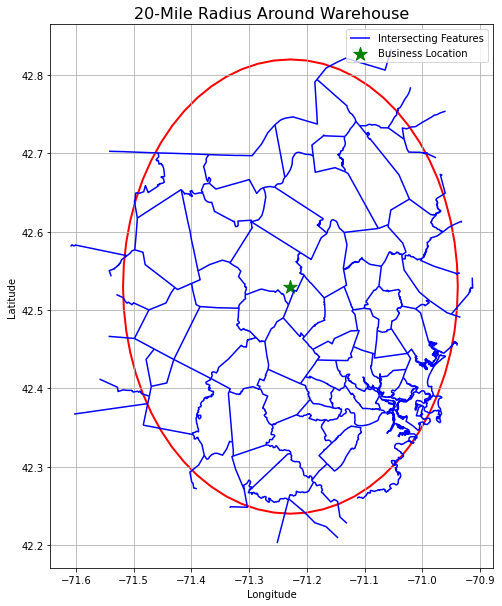

In [86]:
# Load the filtered GeoDataFrame (intersecting features)
filtered_gdf = gpd.read_file("filtered_features_within_20_miles.shp")


business_gdf = gpd.GeoDataFrame(
    {"name": ["Business Location"]}, geometry=[business_location], crs="EPSG:4326"
)
business_gdf = business_gdf.to_crs(filtered_gdf.crs)

# Plot the 20-mile radius and the intersecting points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the delivery zone (20-mile buffer)
delivery_zone_gdf.to_crs(filtered_gdf.crs).plot(ax=ax, color="none", edgecolor="red", linewidth=2, label="20-Mile Radius")

# Plot the intersecting features (points)
filtered_gdf.plot(ax=ax, color="blue", markersize=10, label="Intersecting Features")

business_gdf.plot(ax=ax, color="green", marker="*", markersize=200, label="Business Location")

# Add labels and styling
plt.title("20-Mile Radius Around Warehouse", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()
plt.show()

In [87]:
#Train Classification Model to determine Same Day Delivery Eligibility

# Business location (example: Boston, MA)
business_lat, business_lon = 42.52998149804952, -71.22844677712773

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c * 1000  # Return distance in meters

# Load the filtered features within the 20-mile radius
inside_df = pd.read_csv("filtered_features_within_20_miles.csv")

# Step 2: Create a GeoDataFrame
# Assuming the CSV contains `longitude` and `latitude` columns
gdf = gpd.GeoDataFrame(
    inside_df,
    geometry=gpd.points_from_xy(inside_df["longitude"], inside_df["latitude"]),
    crs="EPSG:26986"  # Replace with the CRS of the original data (e.g., projected CRS like EPSG:26986)
)

# Step 3: Reproject to EPSG:4326 (latitude/longitude)
gdf = gdf.to_crs("EPSG:4326")

# Step 4: Extract latitude and longitude
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y

# Drop the geometry column (optional, if not needed for training)
gdf = gdf.drop(columns=["geometry"])

# Step 5: Save back to CSV (if needed) or use directly for training
gdf.to_csv("filtered_features_in_epsg_4326.csv", index=False)

print("Reprojected data saved to 'filtered_features_in_epsg_4326.csv'")

# Load the filtered features within the 20-mile radius
inside_df = pd.read_csv("filtered_features_in_epsg_4326.csv")

# Add a label for points inside the delivery zone
inside_df["label"] = 1  # 1 = Inside the delivery zone

# Calculate distance for inside points
inside_df["distance_to_business"] = inside_df.apply(
    lambda row: haversine(business_lat, business_lon, row["latitude"], row["longitude"]), axis=1
)
print(inside_df.head())

# Generate random points outside the radius
num_outside_points = 1000  # Number of points to generate
radius_meters = 20 * 1609.34  # 20 miles in meters

outside_points = []
for _ in range(num_outside_points):
    while True:
        # Generate random lat/lon in a wide range
        random_lat = np.random.uniform(41.0, 43.0)  # Approx range for MA
        random_lon = np.random.uniform(-73.0, -69.0)  # Approx range for MA
        
        # Calculate distance to business location
        distance = haversine(business_lat, business_lon, random_lat, random_lon)
        
        # Only keep points outside the radius
        if distance > radius_meters:
            outside_points.append({"latitude": random_lat, "longitude": random_lon, "distance_to_business": distance, "label": 0})
            break

# Convert to DataFrame
outside_df = pd.DataFrame(outside_points)
print(outside_df.head())

Reprojected data saved to 'filtered_features_in_epsg_4326.csv'
   longitude   latitude  label  distance_to_business
0 -71.241579  42.230496      1          33318.745228
1 -71.231996  42.258846      1          30150.320731
2 -71.189113  42.233754      1          33097.081725
3 -71.209928  42.268106      1          29158.868671
4 -71.158387  42.256468      1          30952.681644
    latitude  longitude  distance_to_business  label
0  42.488422 -69.610047         132737.756681      0
1  41.584517 -72.864771         171175.197641      0
2  42.942920 -71.698546          59852.911389      0
3  41.722408 -70.916604          93408.043867      0
4  42.866204 -70.231492          89640.084462      0


In [96]:
# Combine inside and outside points
df = pd.concat([inside_df, outside_df], ignore_index=True)

# Verify the combined dataset
print(combined_df.head())

# Features and target
X = df[["longitude", "latitude", "distance_to_business"]]
y = df["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


   longitude   latitude  label  distance_to_business
0 -71.241579  42.230496      1          33318.745228
1 -71.231996  42.258846      1          30150.320731
2 -71.189113  42.233754      1          33097.081725
3 -71.209928  42.268106      1          29158.868671
4 -71.158387  42.256468      1          30952.681644
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       1.00      1.00      1.00        43

    accuracy                           1.00       245
   macro avg       1.00      1.00      1.00       245
weighted avg       1.00      1.00      1.00       245



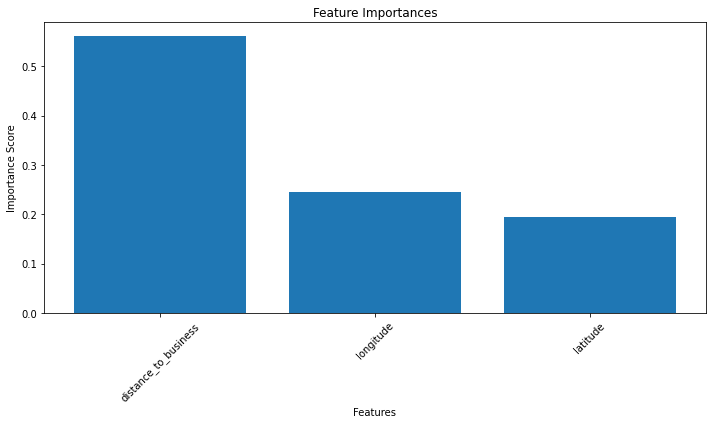

In [97]:
# Get feature importances from the trained Random Forest model
importances = clf.feature_importances_
features = X.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=45)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [107]:
# Load the sampled addresses
test_df = pd.read_csv("sampled_addresses.csv")

# Rename columns
test_df = test_df.rename(columns={"LON": "longitude", "LAT": "latitude"})

test_df.head()


,full_address,longitude,latitude
0,"86 KILLDEER ROAD,WEBSTER, MA, 1570.0",-71.843818,42.051904
1,"119 BARNETT ROAD,SUTTON, MA, 1590",-71.711696,42.100685
2,"358 MAMMOTH ROAD,LOWELL, MA, 1854.0",-71.341278,42.656293
3,"720 HARRISON AVENUE,BOSTON, MA, 2118.0",-71.070911,42.337777
4,"102 DEVON STREET,DORCHESTER, MA, 2121",-71.078111,42.309157


In [108]:
test_df["distance_to_business"] = test_df.apply(
    lambda row: haversine(business_lat, business_lon, row["latitude"], row["longitude"]),
    axis=1
)

# Prepare features for the model
X_test = test_df[["longitude", "latitude", "distance_to_business"]]

# Predict using the trained model
test_df["predicted_label"] = clf.predict(X_test)
test_df["probability_eligible"] = clf.predict_proba(X_test)[:, 1]  # Probability of eligibility

# Display the results
print(test_df)

# Optionally save results to CSV
test_df.to_csv("test_results.csv", index=False)

                                 full_address  longitude   latitude  \
0        86 KILLDEER ROAD,WEBSTER, MA, 1570.0 -71.843818  42.051904   
1           119 BARNETT ROAD,SUTTON, MA, 1590 -71.711696  42.100685   
2         358 MAMMOTH ROAD,LOWELL, MA, 1854.0 -71.341278  42.656293   
3      720 HARRISON AVENUE,BOSTON, MA, 2118.0 -71.070911  42.337777   
4       102 DEVON STREET,DORCHESTER, MA, 2121 -71.078111  42.309157   
5      375 ACORN PARK DRIVE,BELMONT, MA, 2478 -71.154350  42.399307   
6       19 WEBSTER COURT,LAWRENCE, MA, 1841.0 -71.155774  42.717444   
7          3 KIMBALL COURT,WOBURN, MA, 1801.0 -71.167995  42.501164   
8        47 ROSEWOOD LANE,SWANSEA, MA, 2777.0 -71.240188  41.746159   
9          30 INCA ROAD,OAK BLUFFS, MA, 02568 -70.573030  41.452072   
10       35 EUSTIS STREET,CAMBRIDGE, MA, 2140 -71.114470  42.383588   
11     50 MURRAY AVENUE,WORCESTER, MA, 1610.0 -71.807324  42.259641   
12  1401 POULIOT PLACE,WILMINGTON, MA, 1887.0 -71.210989  42.562347   
13    

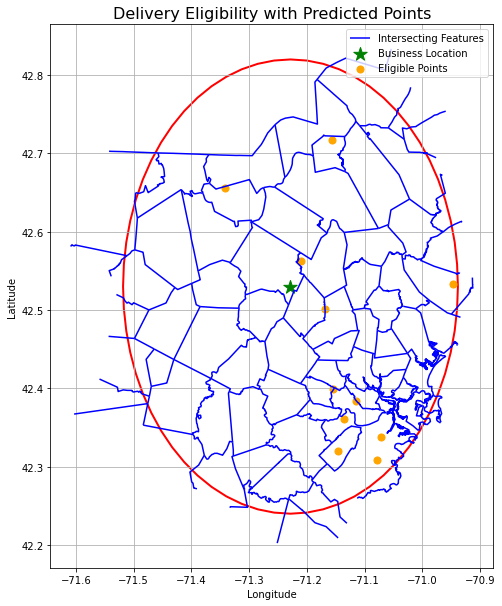

In [109]:
# Load the filtered GeoDataFrame (intersecting features)
filtered_gdf = gpd.read_file("filtered_features_within_20_miles.shp")

# Business location as GeoDataFrame
business_gdf = gpd.GeoDataFrame(
    {"name": ["Business Location"]},
    geometry=[business_location],
    crs="EPSG:4326"
)
business_gdf = business_gdf.to_crs(filtered_gdf.crs)

# Create GeoDataFrame for predicted eligible points
eligible_points = test_df[test_df["predicted_label"] == 1]  # Filter eligible points
eligible_gdf = gpd.GeoDataFrame(
    eligible_points,
    geometry=gpd.points_from_xy(eligible_points["longitude"], eligible_points["latitude"]),
    crs="EPSG:4326"
)
eligible_gdf = eligible_gdf.to_crs(filtered_gdf.crs)

# Plot the 20-mile radius and the intersecting points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the delivery zone (20-mile buffer)
delivery_zone_gdf.to_crs(filtered_gdf.crs).plot(ax=ax, color="none", edgecolor="red", linewidth=2, label="20-Mile Radius")

# Plot the intersecting features (points within radius)
filtered_gdf.plot(ax=ax, color="blue", markersize=10, label="Intersecting Features")

# Plot the business location
business_gdf.plot(ax=ax, color="green", marker="*", markersize=200, label="Business Location")

# Plot the eligible points
eligible_gdf.plot(ax=ax, color="orange", markersize=50, label="Eligible Points")

# Add labels and styling
plt.title("Delivery Eligibility with Predicted Points", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()
plt.show()
